In [7]:
#flag whether running in google colab
import sys
IN_COLAB = 'google.colab' in sys.modules

In [8]:
if IN_COLAB:
    #for those using colab, mount
    from google.colab import drive
    drive.mount('/content/drive')
    train_file = "/content/drive/MyDrive/group_proj/rnn/Data/Train/PCE.csv"

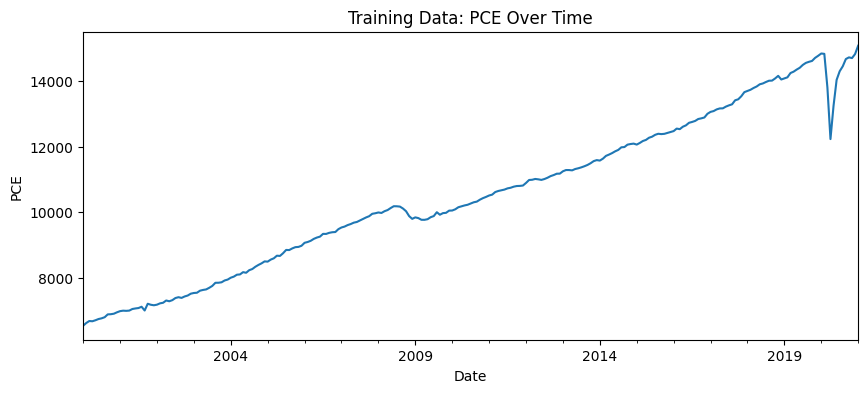

Training sequences: (241, 12), Training targets: (241,)
Testing sequences: (35, 12), Testing targets: (35,)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

# Define relative file paths for training and testing data
train_file = "..\\Data\\Train\\PCE.csv"
test_file  = "..\\Data\\Test\\PCE.csv"


# Load Training Data
train_df = pd.read_csv(train_file, parse_dates=['Date'])
train_df = train_df.rename(columns={'Value': 'PCE'})
train_df.set_index('Date', inplace=True)

# Load Testing Data
test_df = pd.read_csv(test_file, parse_dates=['Date'])
test_df = test_df.rename(columns={'Value': 'PCE'})
test_df.set_index('Date', inplace=True)

# Visualise the trend of the training data
plt.figure(figsize=(10, 4))
train_df['PCE'].plot(title='Training Data: PCE Over Time')
plt.xlabel('Date')
plt.ylabel('PCE')
plt.show()

# Fit the scaler on the training data and transform both train and test sets.
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[['PCE']])
test_scaled = scaler.transform(test_df[['PCE']])

# Convert the scaled data to 1D arrays
train_series = train_scaled.flatten()
test_series  = test_scaled.flatten()

# Create Sequences from the Data
def create_sequences(data, seq_length):
    """
    Creates sequences of length `seq_length` as inputs and the subsequent value as the target.
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i : i + seq_length])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)

# Set the sequence length
sequence_length = 12
X_train, y_train = create_sequences(train_series, sequence_length)
X_test, y_test   = create_sequences(test_series, sequence_length)

print(f"Training sequences: {X_train.shape}, Training targets: {y_train.shape}")
print(f"Testing sequences: {X_test.shape}, Testing targets: {y_test.shape}")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

1. Import the RNN Model

In [36]:
#allows imports from other folders in project
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#from RNN_PCE import RNNModel
from Models.RNN_PCE import RNNModel

# Define computation device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rnn_model = RNNModel().to(device)
print(rnn_model)

RNNModel(
  (rnn): RNN(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


2. Train the RNN Model

In [37]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
num_epochs = 50

for epoch in range(num_epochs):
    rnn_model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = rnn_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)

    # Evaluate on the test set
    rnn_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = rnn_model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
    test_loss /= len(test_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f}")


Epoch 1/50 - Train Loss: 0.1715 - Test Loss: 1.1751
Epoch 2/50 - Train Loss: 0.0711 - Test Loss: 0.5649
Epoch 3/50 - Train Loss: 0.0614 - Test Loss: 0.6619
Epoch 4/50 - Train Loss: 0.0495 - Test Loss: 0.6534
Epoch 5/50 - Train Loss: 0.0398 - Test Loss: 0.4019
Epoch 6/50 - Train Loss: 0.0273 - Test Loss: 0.2591
Epoch 7/50 - Train Loss: 0.0078 - Test Loss: 0.0345
Epoch 8/50 - Train Loss: 0.0036 - Test Loss: 0.0525
Epoch 9/50 - Train Loss: 0.0014 - Test Loss: 0.0805
Epoch 10/50 - Train Loss: 0.0013 - Test Loss: 0.0645
Epoch 11/50 - Train Loss: 0.0011 - Test Loss: 0.0640
Epoch 12/50 - Train Loss: 0.0009 - Test Loss: 0.0559
Epoch 13/50 - Train Loss: 0.0008 - Test Loss: 0.0485
Epoch 14/50 - Train Loss: 0.0008 - Test Loss: 0.0577
Epoch 15/50 - Train Loss: 0.0008 - Test Loss: 0.0552
Epoch 16/50 - Train Loss: 0.0008 - Test Loss: 0.0452
Epoch 17/50 - Train Loss: 0.0009 - Test Loss: 0.0489
Epoch 18/50 - Train Loss: 0.0010 - Test Loss: 0.0531
Epoch 19/50 - Train Loss: 0.0011 - Test Loss: 0.0504
Ep

3. Make Predictions with the RNN Model

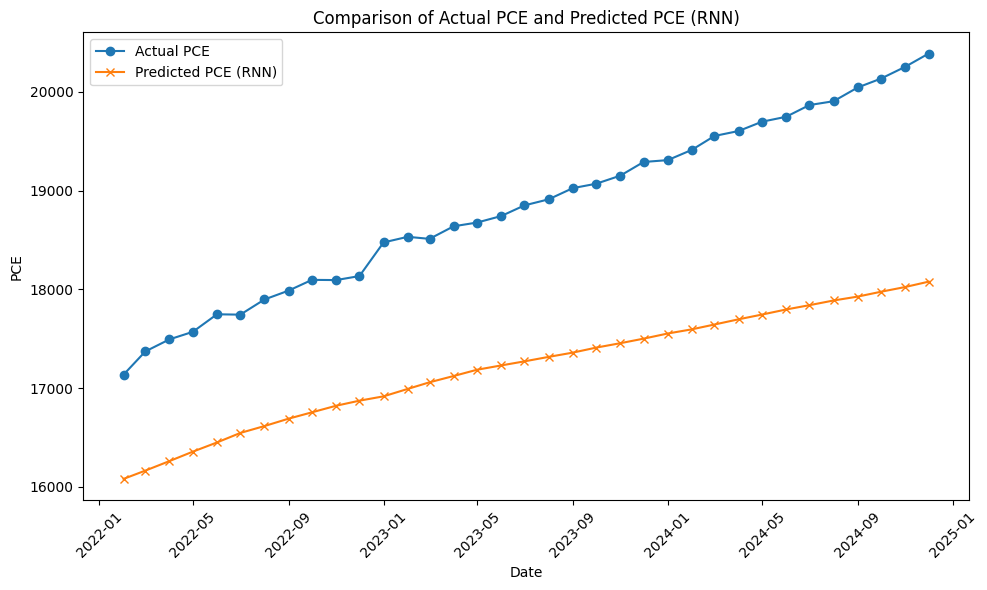

In [38]:
rnn_model.eval()
rnn_predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = rnn_model(inputs)
        rnn_predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())

# Concatenate batches into single arrays
rnn_predictions = np.concatenate(rnn_predictions)
actuals = np.concatenate(actuals)

# Inverse transform the normalised predictions and actual values back to the original scale
rnn_predictions_inv = scaler.inverse_transform(rnn_predictions)
actuals_inv = scaler.inverse_transform(actuals)

# Extract the dates corresponding to the test predictions.
test_dates = test_df.index[sequence_length:]

# Plot the actual vs. predicted PCE values for RNN
plt.figure(figsize=(10, 6))
plt.plot(test_dates, actuals_inv, label='Actual PCE', marker='o')
plt.plot(test_dates, rnn_predictions_inv, label='Predicted PCE (RNN)', marker='x')
plt.legend()
plt.title("Comparison of Actual PCE and Predicted PCE (RNN)")
plt.xlabel("Date")
plt.ylabel("PCE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


LSTM - Natalie's model

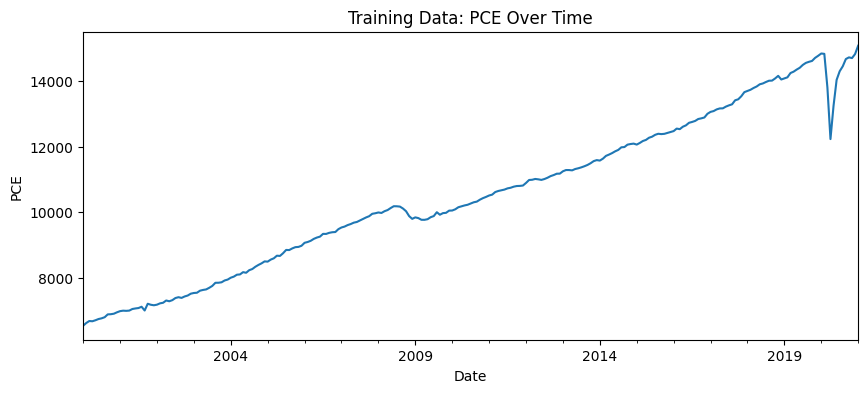

Training sequences: (241, 12), Training targets: (241,)
Testing sequences: (35, 12), Testing targets: (35,)
LSTMModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)
Epoch 1/50 - Train Loss: 0.3666 - Test Loss: 2.0151
Epoch 2/50 - Train Loss: 0.2355 - Test Loss: 1.5042
Epoch 3/50 - Train Loss: 0.1149 - Test Loss: 0.8086
Epoch 4/50 - Train Loss: 0.0550 - Test Loss: 0.3503
Epoch 5/50 - Train Loss: 0.0483 - Test Loss: 0.5583
Epoch 6/50 - Train Loss: 0.0394 - Test Loss: 0.5101
Epoch 7/50 - Train Loss: 0.0321 - Test Loss: 0.2847
Epoch 8/50 - Train Loss: 0.0254 - Test Loss: 0.1894
Epoch 9/50 - Train Loss: 0.0180 - Test Loss: 0.1436
Epoch 10/50 - Train Loss: 0.0109 - Test Loss: 0.0227
Epoch 11/50 - Train Loss: 0.0054 - Test Loss: 0.0019
Epoch 12/50 - Train Loss: 0.0030 - Test Loss: 0.0180
Epoch 13/50 - Train Loss: 0.0036 - Test Loss: 0.0098
Epoch 14/50 - Train Loss: 0.0028 - Test Loss: 0.0011
Epoch 15/50 - Train Loss: 0.0026 - Test Loss: 0.

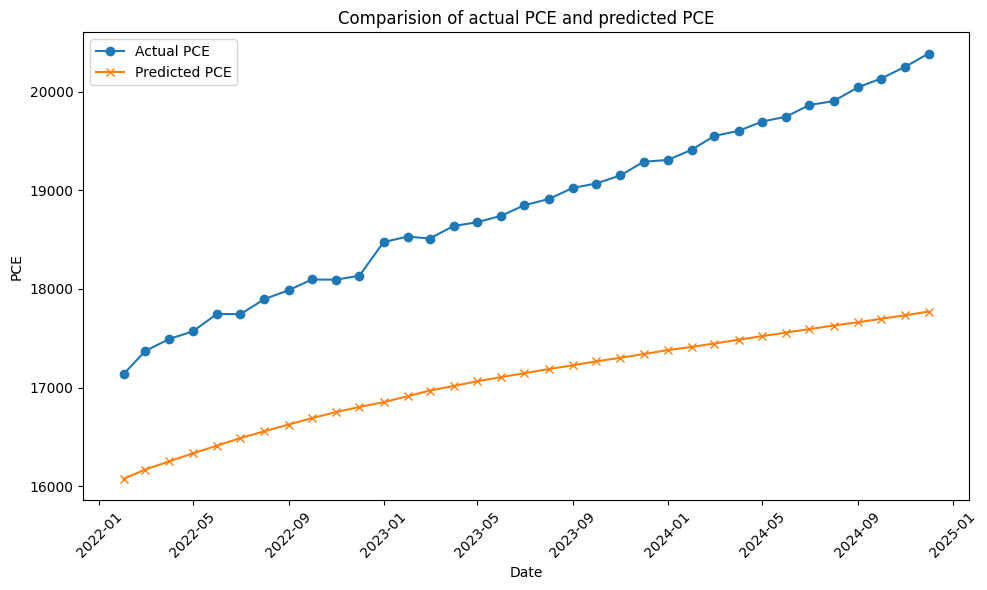

In [39]:
from Models.LSTM_PCE import LSTMModel

# Define file paths for training and testing data
train_file = "..\\Data\\Train\\PCE.csv"
test_file  = "..\\Data\\Test\\PCE.csv"

# Load Training Data
train_df = pd.read_csv(train_file, parse_dates=['Date'])
train_df = train_df.rename(columns={'Value': 'PCE'})
train_df.set_index('Date', inplace=True)

# Load Testing Data
test_df = pd.read_csv(test_file, parse_dates=['Date'])
test_df = test_df.rename(columns={'Value': 'PCE'})
test_df.set_index('Date', inplace=True)

# Visualise the trend of the training data
plt.figure(figsize=(10, 4))
train_df['PCE'].plot(title='Training Data: PCE Over Time')
plt.xlabel('Date')
plt.ylabel('PCE')
plt.show()

# Fit the scaler on the training data and transform both train and test sets.
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[['PCE']])
test_scaled = scaler.transform(test_df[['PCE']])

# Convert the scaled data to 1D arrays
train_series = train_scaled.flatten()
test_series  = test_scaled.flatten()

# Create Sequences from the Data
def create_sequences(data, seq_length):
    """
    Creates sequences of length `seq_length` as inputs and the subsequent value as the target.
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i : i + seq_length])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)

# Set the sequence length
sequence_length = 12
X_train, y_train = create_sequences(train_series, sequence_length)
X_test, y_test   = create_sequences(test_series, sequence_length)

print(f"Training sequences: {X_train.shape}, Training targets: {y_train.shape}")
print(f"Testing sequences: {X_test.shape}, Testing targets: {y_test.shape}")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = LSTMModel().to(device)
print(model)

# Model training
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
    test_loss /= len(test_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f}")

# Making predictions
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())

# Concatenate batches into single arrays
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Inverse transform the normalised predictions and actual values back to the original scale
predictions_inv = scaler.inverse_transform(predictions)
actuals_inv = scaler.inverse_transform(actuals)

# Extract the dates corresponding to the test predictions.
test_dates = test_df.index[sequence_length:]

# Plot the actual vs. predicted PCE values
plt.figure(figsize=(10, 6))
plt.plot(test_dates, actuals_inv, label='Actual PCE', marker='o')
plt.plot(test_dates, predictions_inv, label='Predicted PCE', marker='x')
plt.legend()
plt.title("Comparision of actual PCE and predicted PCE")
plt.xlabel("Date")
plt.ylabel("PCE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

4. Compare LSTM vs. RNN Performance

LSTM Model MSE: 3276705.7500
RNN Model MSE: 2750951.7500


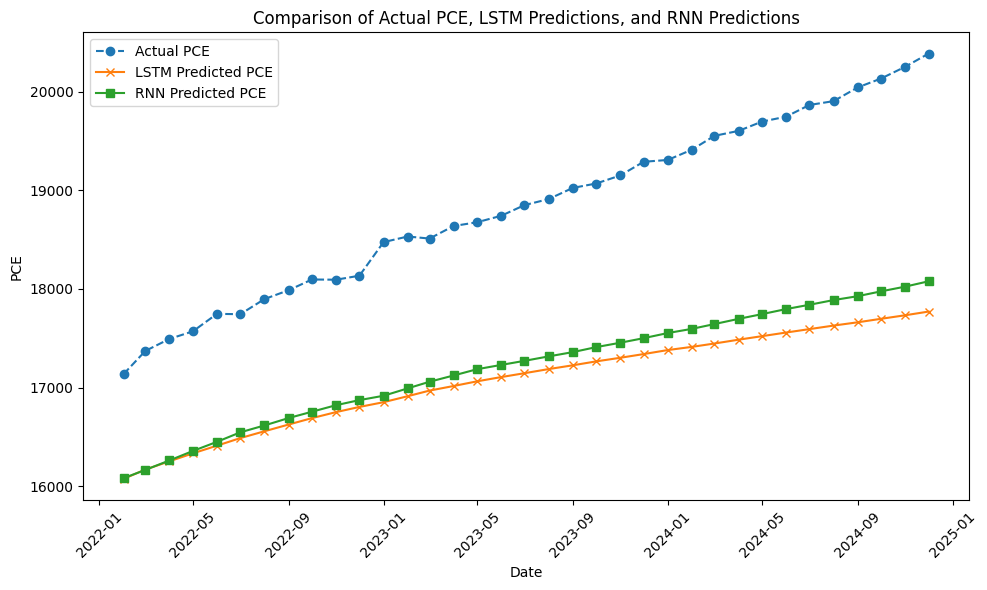

In [40]:
# Compute Mean Squared Error for comparison
from sklearn.metrics import mean_squared_error

lstm_mse = mean_squared_error(actuals_inv, predictions_inv)
rnn_mse = mean_squared_error(actuals_inv, rnn_predictions_inv)

print(f"LSTM Model MSE: {lstm_mse:.4f}")
print(f"RNN Model MSE: {rnn_mse:.4f}")

# Plot LSTM vs RNN predictions
plt.figure(figsize=(10, 6))
plt.plot(test_dates, actuals_inv, label="Actual PCE", marker="o", linestyle="dashed")
plt.plot(test_dates, predictions_inv, label="LSTM Predicted PCE", marker="x")
plt.plot(test_dates, rnn_predictions_inv, label="RNN Predicted PCE", marker="s")
plt.legend()
plt.title("Comparison of Actual PCE, LSTM Predictions, and RNN Predictions")
plt.xlabel("Date")
plt.ylabel("PCE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
